In [1]:
import os

import nibabel as nib
import numpy as np
from nilearn.plotting import plot_roi, plot_img, plot_stat_map

from nimare.dataset import Dataset
from nimare.decode import discrete
from nimare.utils import get_resource_path

In [2]:
###### Load downloaded dataset #######
neurosynth_dset = Dataset.load(os.path.join('./neurosynth_data', "neurosynth_dataset.pkl.gz"))
print(neurosynth_dset)

Dataset(14371 experiments, space='mni152_2mm')


In [3]:
#### Specify the scope of cognitive terms ####
neurosynth_dset_copy = neurosynth_dset.copy()
neurosynth_dset_copy.annotations=neurosynth_dset_copy.annotations.iloc[:,
                                                             [0,1,2,1864+2,1106+2,3153+2,2065+2,91+2,1109+2,2390+2,3145+2,1891+2,
                                                              3163+2,273+2,3146+2,1593+2,260+2,1481+2,3211+2,1979+2,
                                                              451+2,1777+2,2548+2,280+2,3128+2,956+2,2734+2]]

# display the selected cognitive terms
column_names = neurosynth_dset_copy.annotations.columns.tolist()
new_column_names = column_names[:3]
for i in range(3,len(column_names)):
    cleaned_term = column_names[i].split("__")[1]
    print(cleaned_term)
    new_column_names.append(cleaned_term)

# Replace column names
neurosynth_dset_copy.annotations.columns = new_column_names

motor
eye movements
visual perception
pain
action
face
reading
visual
multisensory
visuospatial
auditory
visual attention
language
attention
inhibition
working memory
numerical
cognitive control
memory
reward
autobiographical memory
verbal
emotion
social cognition


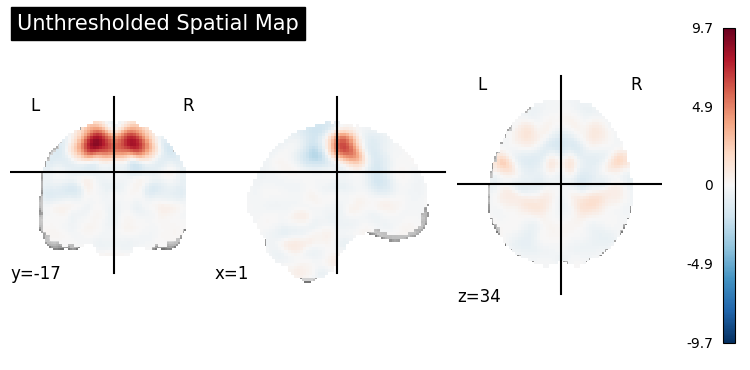

In [4]:
##### Load spatial maps ######
from nilearn import image

# NeuroMark for spatial maps
neuromark_file_path = "Neuromark_fMRI_2.2_modelorder-multi.nii"

# Load nifti images
neuromark_img = image.load_img(neuromark_file_path)

# Sensorimotor: 56, DMN (precuneus): 95, DMN (MPFC): 101
img_SM = image.index_img(neuromark_img, 56)
plot_stat_map(img_SM, title="Unthresholded Spatial Map")

/tmp/ipykernel_148856/1909349830.py:20: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  ICN_SM_thres = masking.unmask(z_thresh, mask_rs)


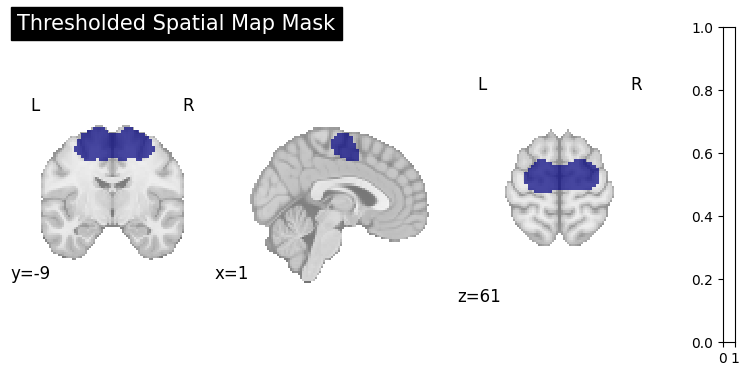

In [5]:
##### Threshold the spatial maps to specify the ROI for decoding #####
from nilearn import masking, datasets
from scipy.stats import zscore

# 1. Load Brain Mask
mask_img = datasets.load_mni152_brain_mask()
mask_rs = image.resample_to_img(mask_img, img_SM, interpolation="nearest",force_resample=True,copy_header=True)

# 2. Apply mask
masked_data = masking.apply_mask(img_SM, mask_rs)

# z-score
z_data = zscore(masked_data, axis=0, nan_policy='omit')

# threshold |z| > 3
threshold = 3
z_thresh = np.where(np.abs(z_data) >= threshold, 1, 0)

# Restore nifti format
ICN_SM_thres = masking.unmask(z_thresh, mask_rs)

plot_roi(ICN_SM_thres, draw_cross=False,title="Thresholded Spatial Map Mask")


# Dummy mask for resampling
arr = np.zeros(neurosynth_dset.masker.mask_img.shape, np.int32)
mask_img_nimare = nib.Nifti1Image(arr, neurosynth_dset.masker.mask_img.affine)

# Resample the thresholded spatial map to be in the same space as the NeuroSynth dataset
ICN_SM_thres_mni152 = image.resample_to_img(ICN_SM_thres, mask_img_nimare, interpolation="nearest",force_resample=True,copy_header=True)

In [6]:
#### Training NeuroSynth Decoder ####

from nimare.decode import discrete

# Get studies with voxels in the mask
ids = neurosynth_dset_copy.get_studies_by_mask(ICN_SM_thres_mni152)

# Train the decoder
decoder = discrete.NeurosynthDecoder(correction="fdr_bh")
decoder.fit(neurosynth_dset_copy)

In [7]:
#### Decode ####

decoded_df = decoder.transform(ids=ids)
decoded_df.sort_values(by="probReverse", ascending=False)

,pForward,zForward,probForward,pReverse,zReverse,probReverse
Term,,,,,,
motor,0.000000e+00,inf,0.416853,5.714893e-180,28.605651,0.674786
eye movements,NaN,NaN,0.436507,1.255302e-07,5.285254,0.631976
action,5.912026e-14,7.510016,0.400493,1.467755e-27,10.877983,0.610139
visual attention,NaN,NaN,0.382826,3.987689e-03,2.879134,0.579309
visuospatial,NaN,NaN,0.372239,4.167178e-04,3.529264,0.568481
attention,3.370160e-116,22.913990,0.348409,6.875312e-09,5.793942,0.548643
pain,9.181554e-30,-11.331315,0.355107,1.024070e-03,3.283829,0.548476
working memory,4.255896e-09,5.873927,0.348996,3.509021e-05,4.137636,0.543657
inhibition,1.708363e-15,-7.960868,0.350032,2.608555e-03,3.010456,0.541904


In [8]:
#### BrainMap Decoder ####

from nimare.decode import discrete

# Get studies with voxels in the mask
ids = neurosynth_dset.get_studies_by_mask(ICN_SM_thres_mni152)

# Decode
decoder = discrete.BrainMapDecoder(correction="fdr_bh")
decoder.fit(neurosynth_dset_copy)
decoded_df = decoder.transform(ids=ids)
decoded_df.sort_values(by="probReverse", ascending=False)

/home/users/ysong30/anaconda3/envs/fmri/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,pForward,zForward,likelihoodForward,pReverse,zReverse,probReverse
Term,,,,,,
motor,0.000000e+00,inf,1.441339,5.714893e-180,28.605651,0.163733
visual,4.085129e-01,8.265135e-01,1.006461,9.353038e-03,2.598873,0.138624
memory,9.691869e-01,3.862815e-02,0.938963,5.946423e-01,-0.532121,0.114108
attention,1.838037e-05,4.283708e+00,1.171541,6.875312e-09,5.793942,0.095001
working memory,5.194925e-03,2.794692e+00,1.134622,3.509021e-05,4.137636,0.054822
action,2.170422e-10,6.348771e+00,1.366431,1.467755e-27,10.877983,0.053617
auditory,9.854723e-01,1.820873e-02,0.894990,1.357842e-01,-1.491676,0.049625
emotion,9.798428e-01,-2.526605e-02,0.887025,1.481385e-03,-3.178306,0.040738
language,9.999966e-01,-4.204964e-06,0.780283,6.593925e-04,-3.405929,0.038047


In [9]:
#### ROI Assoicaiton Decoder (used in Margulias et al. 2016) ####

from nimare.decode import discrete

decoder = discrete.ROIAssociationDecoder(ICN_SM_thres_mni152)
decoder.fit(neurosynth_dset_copy)

# The `transform` method doesn't take any parameters.
decoded_df = decoder.transform()
decoded_df.sort_values(by="r", ascending=False)

,r
feature,
motor,0.300255
action,0.089180
eye movements,0.072698
attention,0.034519
working memory,0.029189
visuospatial,0.026658
inhibition,0.022357
pain,0.011743
visual attention,0.006437
